# Generate figure to show possible hypotheses


### 3 main hypotheses:

1. aperiodic change only
2. Infrequent bursts
3. Vanilla theta



https://github.com/neurodsp-tools/neurodsp/tree/main/tutorials/sim

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_random_walk, sim_oscillation
from neurodsp.filt import filter_signal

# Import sim functions
from neurodsp.sim import sim_combined # sim_peak_oscillation
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

from neurodsp.timefrequency import amp_by_time, robust_hilbert, phase_by_time
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure
from neurodsp.filt.utils import infer_passtype, remove_filter_edges

import scipy as sp 

import fooof

from scipy.stats import zscore

import seaborn as sns
sns.set_context("talk")

# Set the random seed, for consistency simulating data
set_random_seed(0)

## Define functions

In [87]:
def sim_peak_oscillation(sig_ap, fs, freq, bw, height):
    
    from itertools import repeat

    import numpy as np
    from scipy.linalg import norm

    from neurodsp.sim.info import get_sim_func
    from neurodsp.utils.decorators import normalize
    from neurodsp.utils.data import create_times
    """Simulate a signal with an aperiodic component and a specific oscillation peak.
    Parameters
    ----------
    sig_ap : 1d array
        The timeseries of the aperiodic component.
    fs : float
        Sampling rate of ``sig_ap``.
    freq : float
        Central frequency for the gaussian peak in Hz.
    bw : float
        Bandwidth, or standard deviation, of gaussian peak in Hz.
    height : float
        Relative height of the gaussian peak at the central frequency ``freq``.
        Units of log10(power), over the aperiodic component.
    Returns
    -------
    sig : 1d array
        Time series with desired power spectrum.
    Notes
    -----
    - This function creates a time series whose power spectrum consists of an aperiodic component
    and a gaussian peak at ``freq`` with standard deviation ``bw`` and relative ``height``.
    - The periodic component of the signal will be sinusoidal.
    Examples
    --------
    Simulate a signal with aperiodic exponent of -2 & oscillation central frequency of 20 Hz:
    >>> from neurodsp.sim import sim_powerlaw
    >>> fs = 500
    >>> sig_ap = sim_powerlaw(n_seconds=10, fs=fs)
    >>> sig = sim_peak_oscillation(sig_ap, fs=fs, freq=20, bw=5, height=7)
    """

    sig_len = len(sig_ap)
    times = create_times(sig_len / fs, fs)

    # Construct the aperiodic component and compute its Fourier transform
    # Only use the first half of the frequencies from the FFT since the signal is real
    sig_ap_hat = np.fft.fft(sig_ap)[0:(sig_len // 2 + 1)]

    # Create the range of frequencies that appear in the power spectrum since these
    # will be the frequencies in the cosines we sum below
    freqs = np.linspace(0, fs / 2, num=sig_len // 2 + 1, endpoint=True)

    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights = np.array([height * np.exp(-(lin_freq - freq) ** 2 / (2 * bw ** 2)) \
        for lin_freq in freqs])

    # Build an array of the sum of squares of the cosines to use in the amplitude calculation
    cosine_norms = np.array([norm(np.cos(2 * np.pi * lin_freq * times), 2) ** 2 \
        for lin_freq in freqs])

    # Build an array of the amplitude coefficients
    cosine_coeffs = np.array([\
        (-np.real(sig_ap_hat[ell]) + np.sqrt(np.real(sig_ap_hat[ell]) ** 2 + \
        (10 ** rel_heights[ell] - 1) * np.abs(sig_ap_hat[ell]) ** 2)) / cosine_norms[ell] \
        for ell in range(cosine_norms.shape[0])])

    # Add cosines with the respective coefficients and with a random phase shift for each one
    sig_periodic = np.sum(np.array([cosine_coeffs[ell] * \
                                   np.cos(2 * np.pi * freqs[ell] * times + \
                                          2 * np.pi * np.random.rand()) \
                          for ell in range(cosine_norms.shape[0])]), axis=0)

    sig = sig_ap + sig_periodic

    return sig

## hypothesis 1: aperiodic change only

In [146]:
# theta only oscillations
freqs, psd_theta_high = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,2], 
                                                     periodic_params = [], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

freqs, psd_theta_low = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,1],
                                                    periodic_params = [], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

In [154]:
# also create corresponding time series
# time_high = zscore(np.real(np.fft.ifft(psd_theta_high)))
# time_low = zscore(np.real(np.fft.ifft(psd_theta_low)))

time_high = np.fft.ifft(psd_theta_high)
time_low = np.fft.ifft(psd_theta_low)

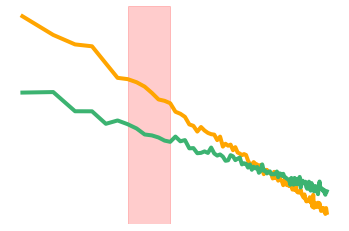

In [168]:
plt.loglog(freqs, psd_theta_high, color = 'orange', linewidth = 4)
plt.loglog(freqs, psd_theta_low, color = 'mediumseagreen', linewidth = 4)
plt.axvspan(4, 7, alpha = 0.2, color = 'red')
plt.axis('off')

# plt.savefig('../New_saved_files/FOOOF_results/figure_1_hyp_1.tiff', format='tiff')

plt.show()

In [164]:
# theta only oscillations
freqs, psd_theta_high = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,2], 
                                                     periodic_params = [6, 1, 2], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

freqs, psd_theta_low = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,1],
                                                    periodic_params = [6, 1, 2], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

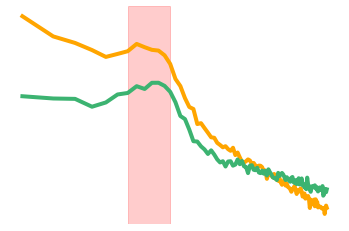

In [166]:
plt.loglog(freqs, psd_theta_high, color = 'orange', linewidth = 4)
plt.loglog(freqs, psd_theta_low, color = 'mediumseagreen', linewidth = 4)
plt.axvspan(4, 7, alpha = 0.2, color = 'red')
plt.axis('off')

plt.savefig('../New_saved_files/FOOOF_results/figure_1_hyp_1_1.tiff', format='tiff')

plt.show()

# Hypothesis 2: infrequent bursts

In [160]:
# theta only oscillations
freqs, psd_theta_high = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,2],
                                            periodic_params=[6, 1.2, 2], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

freqs, psd_theta_low = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,2],
                                            periodic_params=[6, 0.8, 2], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

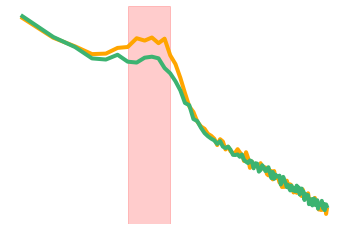

In [161]:
plt.loglog(freqs, psd_theta_high, color = 'orange', linewidth = 4)
plt.loglog(freqs, psd_theta_low, color = 'mediumseagreen', linewidth = 4)
plt.axis('off')
plt.axvspan(4, 7, alpha = 0.2, color = 'red')
plt.savefig('../New_saved_files/FOOOF_results/figure_1_hyp_2.tiff', format='tiff')

plt.show()

# Hypothesis 3: vanilla theta

In [162]:
# theta only oscillations
freqs, psd_theta_high = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,2],
                                            periodic_params=[6, 2, 2], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

freqs, psd_theta_low = fooof.sim.gen_power_spectrum(freq_range=[1,55], aperiodic_params=[0,2],
                                            periodic_params=[6, 1, 2], nlv=0.05,
                                            freq_res=0.5, f_rotation=25, return_params=False)

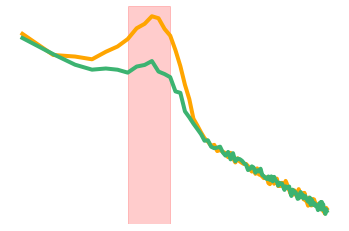

In [163]:
plt.loglog(freqs, psd_theta_high, color = 'orange', linewidth = 4)
plt.loglog(freqs, psd_theta_low, color = 'mediumseagreen', linewidth = 4)
plt.axvspan(4, 7, alpha = 0.2, color = 'red')

plt.axis('off')
plt.savefig('../New_saved_files/FOOOF_results/figure_1_hyp_3.tiff', format='tiff')

plt.show()

## Time series

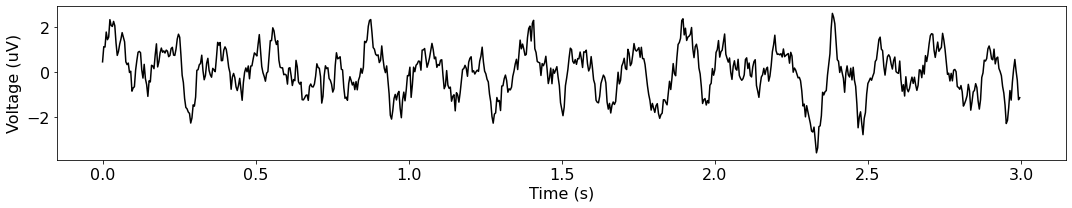

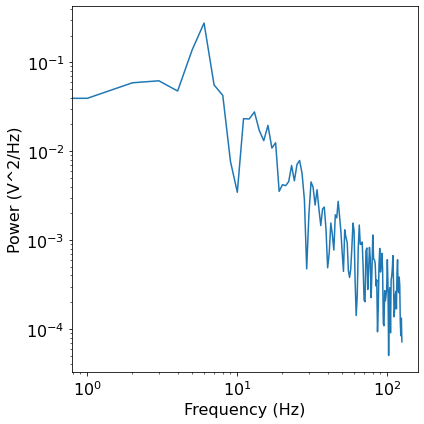

In [46]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                        'tau_r' : 0.002, 'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 6}}

# Simulate an oscillation over an aperiodic component
signal = sim_combined(n_seconds, fs, components)

# Plot the simulated data, in the time domain
plot_time_series(times, signal)

# Plot the simulated data, in the frequency domain
freqs, psd = compute_spectrum(signal, fs)
plot_power_spectra(freqs, psd)

In [109]:
fs = 250
n_seconds = 10
times = create_times(n_seconds, fs)

# simulate aperiodic signals
sig_ap = sim_powerlaw(n_seconds, fs, exponent=-2.0)

# add theta oscillation to aperiodic signal
sig_high = sim_peak_oscillation(sig_ap, fs=fs, freq=6, bw=3, height=1)
sig_low = sim_peak_oscillation(sig_ap, fs=fs, freq=6, bw=3, height=2)

freqs, psd_high = compute_spectrum(sig_high, fs)
freqs, psd_low = compute_spectrum(sig_low, fs)

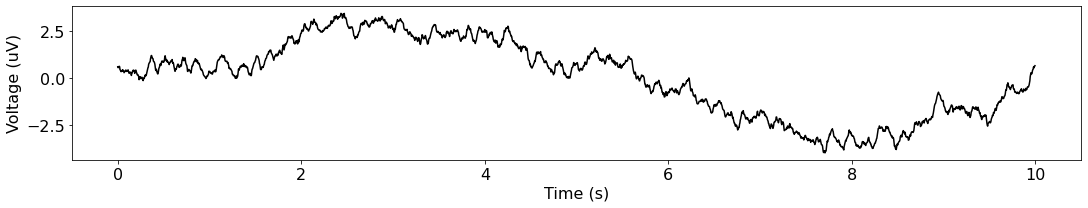

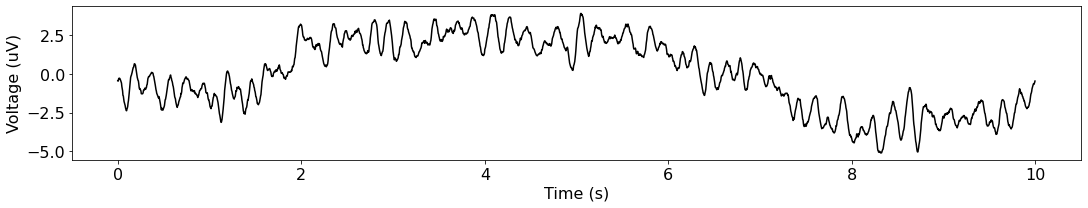

In [110]:
plot_time_series(times, sig_high)
plot_time_series(times, sig_low)

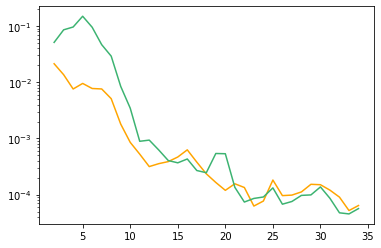

In [111]:
plt.semilogy(freqs[2: 35], psd_high[2: 35], color = 'orange')
plt.semilogy(freqs[2: 35], psd_low[2: 35], color = 'mediumseagreen')
plt.show()

# Hilbert figure explain

In [3]:
N_SECONDS = 3
FS = 250
FREQ = 6
F_RANGE = [4,8]

# time variables
TIME_LOCK_EVENT = 250 # 1 seconds
TIME_POINTS = np.linspace(0, N_SECONDS, N_SECONDS*FS) 
TRANSITION = 100 # time-points for transitioning amplitude --> 400ms
WEIGHT = 'linear'

In [4]:
def create_weights(type="linear"):
    '''
    This weight vector currently is linearly spaced but we might use a gaussian change later 
    Parameters
    ----------
    type : String ("linear" / "sigmoid" / "gaussian")
        The name of the weight vector used in the function to change the signal
    
    Returns
    ----------
    weight : 1d array
        linearly spaced weight vector
    '''
    #if type=="sigmoid":
    #if type=="gaussian":
    #if type=="linear":    ### OR just an 'else' here to reiterate linearly spaced weight vector as default...
    weight = np.zeros(len(TIME_POINTS))
    weight[TIME_LOCK_EVENT:TIME_LOCK_EVENT+TRANSITION] = np.linspace(0, 1, TRANSITION)
    weight[TIME_LOCK_EVENT+TRANSITION:] = 1
    
    return weight

In [5]:
weights = create_weights()


In [6]:
set_random_seed(0)

per_start = sim_oscillation(N_SECONDS, FS, FREQ, 'sine')
aper = sim_powerlaw(N_SECONDS, FS, exponent=-1, f_range=None)
combi_per = (per_start * (1-weights)) * 0.2 + (per_start*weights) * 0.5

# Add periodic and aperiodic signal
full_signal = combi_per + aper

In [7]:
sig_filtered, filter_kernel = filter_signal(full_signal, FS, infer_passtype(F_RANGE), f_range=F_RANGE,
                                           remove_edges=False, return_filter=True)
amp = np.abs(robust_hilbert(sig_filtered, increase_n=False))

phase = phase_by_time(full_signal, FS, f_range=[4,8], remove_edges=False)


Text(0, 0.5, 'Voltage (uV)')

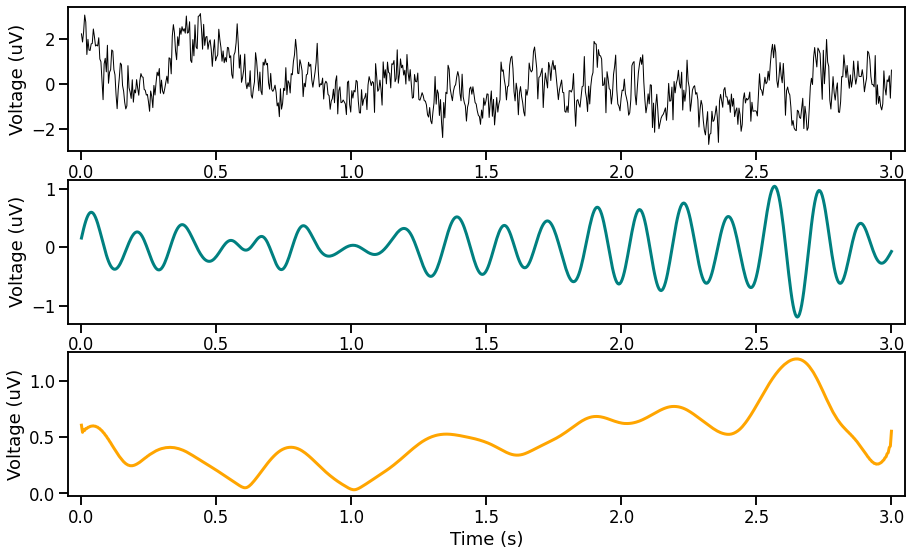

In [142]:
fig, axs = plt.subplots(3, figsize=(15,9))


axs[0].plot(TIME_POINTS, full_signal, color='k', label='signal', lw=1)
axs[1].plot(TIME_POINTS, sig_filtered, color='teal', label='filtered', lw=3)
axs[2].plot(TIME_POINTS, amp, color='orange', label='envelope', lw=3)

axs[0].set_xlim([-0.05, 3.05])
axs[1].set_xlim([-0.05, 3.05])
axs[2].set_xlim([-0.05, 3.05])


axs[2].set_xlabel('Time (s)')
axs[0].set_ylabel('Voltage (uV)')
axs[1].set_ylabel('Voltage (uV)')
axs[2].set_ylabel('Voltage (uV)')

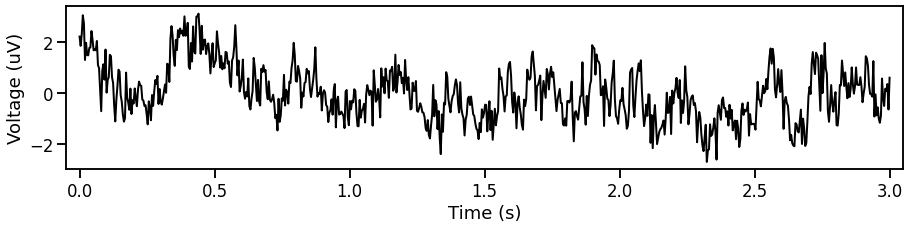

In [143]:
fig, axs = plt.subplots(1, figsize=(15,3))

axs.plot(TIME_POINTS, full_signal, color='k', label='signal', lw=2)

axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])

axs.set_xlabel('Time (s)')
axs.set_ylabel('Voltage (uV)')


plt.savefig('../figures/hypothesis_figures/raw_signal.tiff', format='tiff')


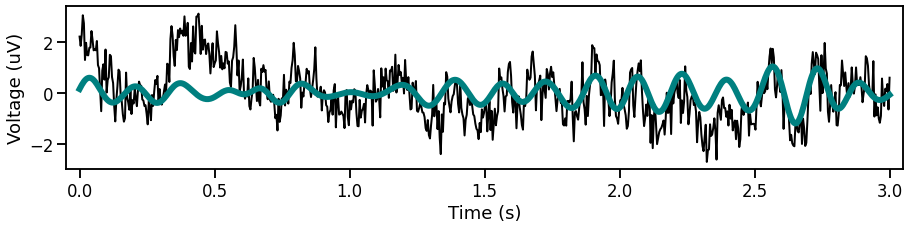

In [144]:
fig, axs = plt.subplots(1, figsize=(15,3))

axs.plot(TIME_POINTS, full_signal, color='k', label='signal', lw=2)
axs.plot(TIME_POINTS, sig_filtered, color='teal', label='filtered', lw=6)

axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])

axs.set_xlabel('Time (s)')
axs.set_ylabel('Voltage (uV)')

plt.savefig('../figures/hypothesis_figures/raw_and_filt.tiff', format='tiff')

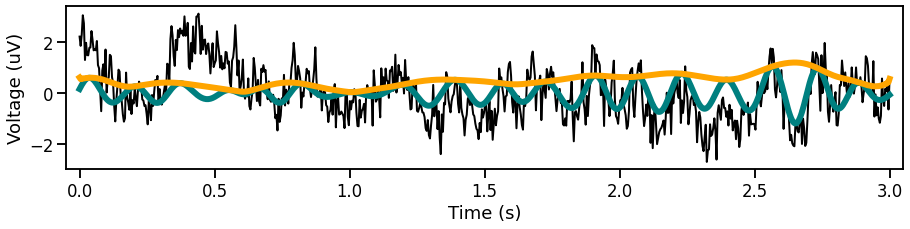

In [15]:
fig, axs = plt.subplots(1, figsize=(15,3))

axs.plot(TIME_POINTS, full_signal, color='k', label='signal', lw=2)
axs.plot(TIME_POINTS, sig_filtered, color='teal', label='filtered', lw=6)
axs.plot(TIME_POINTS, amp, color='orange', label='envelope', lw=6)

axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])

axs.set_xlabel('Time (s)')
axs.set_ylabel('Voltage (uV)')

plt.savefig('../figures/hypothesis_figures/raw_and_filt_and_env.tiff', format='tiff')

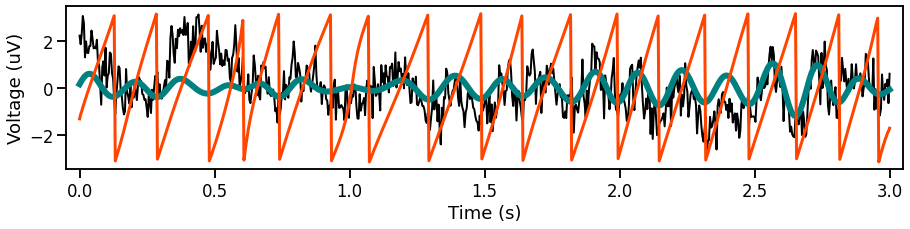

In [16]:
fig, axs = plt.subplots(1, figsize=(15,3))

axs.plot(TIME_POINTS, full_signal, color='k', label='signal', lw=2)
axs.plot(TIME_POINTS, sig_filtered, color='teal', label='filtered', lw=6)
axs.plot(TIME_POINTS, phase, color='orangered', label='envelope', lw=3)

axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])
axs.set_xlim([-0.05, 3.05])

axs.set_xlabel('Time (s)')
axs.set_ylabel('Voltage (uV)')

plt.savefig('../figures/hypothesis_figures/raw_and_filt_and_phase.tiff', format='tiff')